In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos

In [3]:
db_sorted = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
ii=2
data_dir_full = db_sorted['data_dir_full'][ii]
ani = db_sorted.index[ii][0]#'e15_13f1'#'e13_26m1'
sess=db_sorted['sess_name'][ii]#'e15_13f1_220117'#'e13_26m1_210913'
print(sess)

e15_13f1_220118


In [11]:
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
savefn_full = os.path.join(data_dir,'per_field_metrics_shtest_with_1cp.p')
# pickle.dump(per_field_metrics_all,open(savefn_full,'wb'))
per_field_metrics_all=pickle.load(open(savefn_full,'rb'))
per_field_metrics_one = per_field_metrics_all.loc[ani,sess]

/tmp/ipykernel_626847/3496003563.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  per_field_metrics_one = per_field_metrics_all.loc[ani,sess]


In [55]:
# load data
mat_to_return=prep.load_stuff(data_dir_full)
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
ripples = mat_to_return['ripples']
sleep_state_episodes = mat_to_return['SleepStateEpisodes']
cell_metrics=mat_to_return['cell_metrics']
mergepoints = mat_to_return['mergepoints']
cell_type_mask = mat_to_return['cell_type_mask']
res_all_epochs_d, ripple_time_ints_epochs_d = prep.get_spike_count_rate_participation_in_ripple_all(cell_metrics,
                                                                                                    ripples,
                                                                                                    mergepoints,
                                                                                                   )


prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df=dpp.group_into_trialtype(spk_beh_df)
cell_cols_d = prep_res['cell_cols_d']
# beh_df = prep_res['beh_df']
# beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']

In [4]:
res=dpp.load_spk_beh_df(data_dir_full,load_only=True)
if res is not None:
    spk_beh_df = res['spk_beh_df']
    spk_beh_df,_ = dpp.add_lin_binned(spk_beh_df,bin_size=2.2,nbins=None)
    trial_index_to_index_within_df = dpp.trial_index_to_index_within_trialtype(spk_beh_df)
pf_res_recombine = pfrc.main(data_dir_full,force_reload=False,load_only=True)
all_fields_recombined=pf_res_recombine['all_fields_recombined']
pf_params_recombined = pf_res_recombine['params_recombined']
fr_map_res = fmos.main(data_dir_full,force_reload=False,load_only=True)
fr_map_trial_df = fr_map_res['fr_map_trial_df']
sw_res = sdos.main(data_dir_full,force_reload=False,load_only=True)
pval = sw_res['pval']

best_n = sw_res['best_n']

X_pwc = sw_res['X_pwc']

X_raw = sw_res['X_raw']
changes_df = sw_res['changes_df']

sw_info_res=gasam.main(data_dir_full,force_reload=False,load_only=True)
if sw_info_res is None:
    sw_info_res=gasam.main(data_dir_full,force_reload=True,load_only=False)
all_sw_d = sw_info_res['all_sw_d']
all_sw_with_metrics_d = sw_info_res['all_sw_with_metrics_d']


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/fr_map_with_int.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/sw_res_afterheadscan_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/switch_analysis/all_sw_info.p exists; loading---


In [23]:
ti =0

In [24]:
all_sw_on = all_sw_d.loc[ti].query('switch==1')

In [199]:
ii=2
row=per_field_metrics_one.loc[ti].query('si>0.5&fit_var_ratio>0.4').iloc[ii]
tt,uid,field_id=row.name


In [200]:
all_sw_on.set_index(['trialtype','uid','field_index']).loc[(tt,uid,field_id),:]

/tmp/ipykernel_626847/1310630697.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_sw_on.set_index(['trialtype','uid','field_index']).loc[(tt,uid,field_id),:]


,,,time,speed_gauss,field_pos,trial_index,switch,index_within,switch_trial,switch_trial_frac,pre_ntrials_in_segment,post_ntrials_in_segment
trialtype,uid,field_index,,,,,,,,,,
0.0,58,0,7221.7616,23.051817,31.0,22,1.0,12,12.0,0.8,12,3


(<Figure size 432x288 with 2 Axes>, <Axes: xlabel='Position'>)

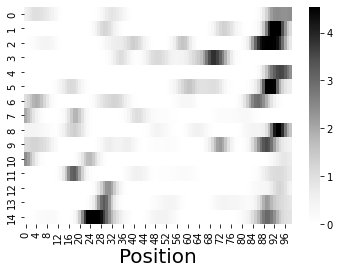

In [201]:
frmapone=fr_map_trial_df.loc[(ti,tt,uid),:].dropna(axis=1,how='all')
ph.heatmap(frmapone.T)

In [202]:
import pynapple as nap

In [203]:
spk_beh_df_sub = spk_beh_df.loc[spk_beh_df['trial_type']==(ti,tt)]
spk_beh_df_sub=spk_beh_df_sub.rolling(3,axis=0).mean()[3::3]
trial_ind = 22
ma_d = {}
ma_d['before']=spk_beh_df_sub['trial'] < trial_ind
ma_d['after']=spk_beh_df_sub['trial'] >= trial_ind
corrmat_d = {}
for k,ma in ma_d.items():
    corrmat = spk_beh_df_sub.loc[ma][cell_cols_d['all']].corr()
    corrmat_d[k] = corrmat

corrmat_d = pd.concat(corrmat_d,axis=0)

corr_diff_onecell = corrmat_d[uid].unstack().diff().iloc[-1].sort_values().dropna()

/tmp/ipykernel_626847/1944806608.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['task', 'trial_type'], dtype='object')
  spk_beh_df_sub=spk_beh_df_sub.rolling(3,axis=0).mean()[3::3]


In [204]:
# uid_to_include=np.concatenate([corr_diff_onecell.iloc[-3:].index, corr_diff_onecell.iloc[:3].index])
uid_to_include=corrmat_d.loc['before',uid].sort_values(ascending=False).dropna().index[1:4]
# uid_to_include=corrmat_d.loc['before',uid].sort_values(ascending=True).dropna().index[1:4]

In [205]:
corrmat_d.loc[(slice(None),uid),uid_to_include]

,,126,307,130
before,58,0.189796,0.171541,0.137990
after,58,0.048688,0.027960,0.062684


In [206]:
corrmat_d.loc['before',uid].sort_values(ascending=False).dropna().iloc[1:10]

126    0.189796
307    0.171541
130    0.137990
359    0.127226
155    0.122183
90     0.110401
170    0.099066
82     0.097159
296    0.095144
Name: (before, 58), dtype: float64

(<Figure size 432x288 with 2 Axes>, <Axes: xlabel='Position'>)

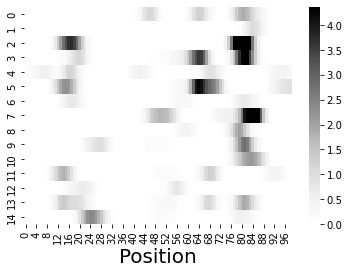

In [209]:
frmapone=fr_map_trial_df.loc[(ti,tt,130),:].dropna(axis=1,how='all')
ph.heatmap(frmapone.T)

In [172]:
spk_selected=spk_beh_df_sub[[uid,*uid_to_include]].T

(4000.0, 5000.0)

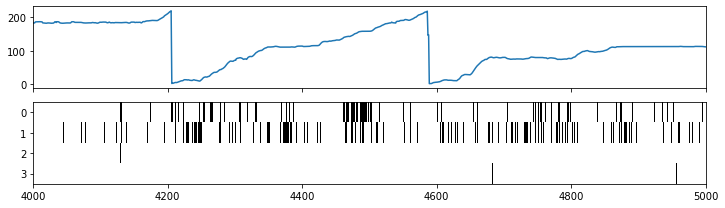

In [179]:
fig,axs=plt.subplots(2,1,figsize=(10,3),sharex=True)
ax=axs[0]
# ax.plot(spk_beh_df_sub['trial'].values)
ax.plot(spk_beh_df_sub['lin'].values)
ax=axs[1]
# ph.heatmap(spk_selected,ax=ax,cbar=False,vmax=0.2)
ax.imshow(spk_selected,vmax=0.2,aspect='auto',cmap='Greys',interpolation='none')
plt.tight_layout()
ax.set_xlim([4000,5000])

<StemContainer object of 3 artists>

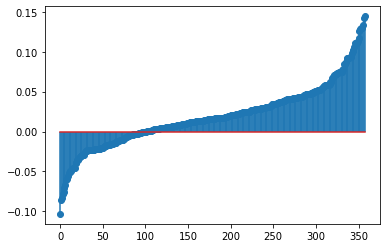

In [88]:
plt.stem(corr_diff_onecell)

<StemContainer object of 3 artists>

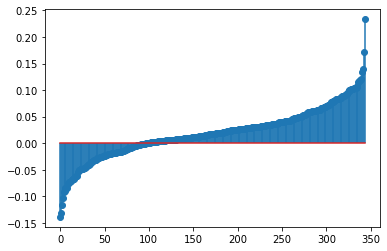

In [84]:
plt.stem(corr_diff_onecell)

<StemContainer object of 3 artists>

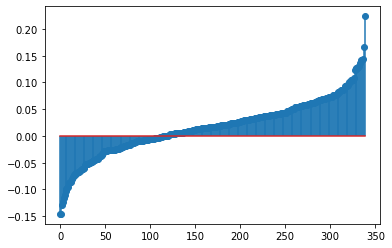

In [90]:
plt.stem(corr_diff_onecell)

[(0.0, 0.4)]

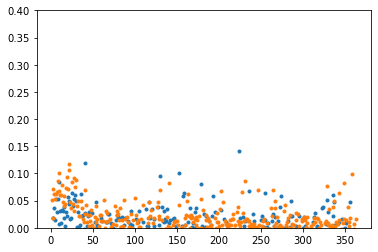

In [63]:
ax=corrmat_d['before'].loc[uid].plot(marker='.',linestyle='none')
ax=corrmat_d['after'].loc[uid].plot(ax=ax,marker='.',linestyle='none')
ax.set(ylim=(0,0.4))


In [54]:
spk_beh_df_sub.loc[ma]

,1,2,3,4,5,6,7,8,9,10,...,trial_type,segment,dist_to_maze,off_track,on_track,off_track_event,pause_event,directed_locomotion,low_speed,lin_binned
5025,0,0,0,0,1,1,4,2,0,2,...,"(0, 0.0)",3.0,0.375855,False,True,False,False,True,False,0
5026,0,0,0,0,0,0,0,0,0,1,...,"(0, 0.0)",3.0,0.389943,False,True,False,False,True,False,0
5027,0,1,0,0,2,2,2,4,3,1,...,"(0, 0.0)",3.0,0.179165,False,True,False,False,True,False,0
5028,0,1,1,0,2,3,2,2,2,5,...,"(0, 0.0)",3.0,0.059385,False,True,False,False,True,False,0
5029,0,0,3,2,1,3,3,3,1,3,...,"(0, 0.0)",3.0,0.278633,False,True,False,False,True,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60178,0,0,0,1,0,1,0,3,1,3,...,"(0, 0.0)",3.0,0.371671,False,True,False,False,True,False,0
60179,0,0,1,0,1,1,0,1,0,3,...,"(0, 0.0)",3.0,0.060107,False,True,False,False,True,False,0
60180,0,1,1,1,1,1,2,2,1,2,...,"(0, 0.0)",3.0,0.262610,False,True,False,False,True,False,0
60181,0,0,0,0,0,0,0,1,0,2,...,"(0, 0.0)",3.0,0.320093,False,True,False,False,True,False,0
